In [1]:
# some libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as ac
#import cmasher as cm
import quantities

import sfe_prescriptions as sfes

import fb_models

We want to decide on the paramteres for the evolution of Wind-Blown Bubbkles (WBBs), Supernovae blast waves (SNs), and superbubbles (SBs?) for a series of numerical experiments comparing codes with differeent discretization techniques and implementations of various schemes. For All Simulations we would like to accept the same cooling and heating functions, and therefore the same basic treatment of the background ISM. The simplest thing to go with is a source term to the energy equation $\rho\mathcal{L} = n^2\Lambda(T) - n\Gamma(T)$ with $n$ the number density of particles and $T = P\mu/k_B \rho$ with $\mu = \rho/n$ with $\rho$ the mass density.

The simplest such source term I can think of is the treatment given in El-Badry+2019 (also used elsewhere I believe) of a piecewise power-law cooling function. Defined below:

In [2]:
def Lambda(T):
    """
    Returns the cooling function Lambda(T) in erg/s cm^3
    """
    T_cooling_curve = np.array([
        0.99999999e1,
        1.0e+02, 6.0e+03, 1.75e+04,
        4.0e+04, 8.7e+04, 2.30e+05,
        3.6e+05, 1.5e+06, 3.50e+06,
        2.6e+07, 1.0e+12
    ])

    lambda_cooling_curve = np.array([
        1e-30,
        1.00e-27, 2.00e-26, 1.50e-22,
        1.20e-22, 5.25e-22, 5.20e-22,
        2.25e-22, 1.25e-22, 3.50e-23,
        2.10e-23, 4.12e-21
    ])

    exponent_cooling_curve = np.array([
        3.,
        0.73167566, 8.33549431, -0.26992783,
        1.89942352, -0.00984338, -1.8698263,
        -0.41187018, -1.50238273, -0.25473349,
        0.5000359, 0.5
    ])

    # Find the appropriate index k
    k = len(T_cooling_curve) - 1
    while k >= 0:
        if T >= T_cooling_curve[k]:
            break
        k -= 1

    # Calculate cooling value
    if T > T_cooling_curve[0]:
        cool = (lambda_cooling_curve[k] *
                (T / T_cooling_curve[k]) ** exponent_cooling_curve[k])
    else:
        cool = 1.0e-30
    return cool

def Gamma(T):
    """
    Returns the heating function Gamma(T) in erg/s
    """
    G0 = 2e-26
    T_PE = 15000
    return G0*(T<T_PE)

We can demonstrate how this cooling function acts at an assumed density of $n = 1\, {\rm cm}^{-3}$

Text(0, 0.5, '$n_{\\rm H}\\Lambda,\\,\\, \\Gamma$ [erg s$^{-1}$]')

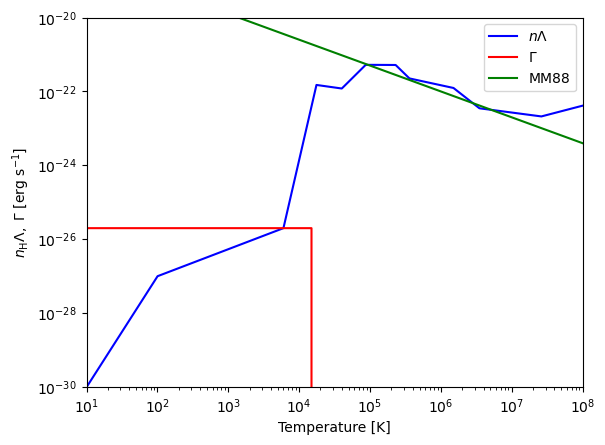

In [3]:
Tlin = np.logspace(1, 8, 1000)

plt.plot(Tlin, [Lambda(T) for T in Tlin], label=r'$n\Lambda$', color='blue')
plt.plot(Tlin, Gamma(Tlin), label=r'$\Gamma$', color='red')
plt.plot(Tlin, 1e-22*(Tlin/1e6)**-0.7, label=r'MM88', color='green')

plt.ylim(1e-30, 1e-20)
plt.xlim(1e1, 1e8)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Temperature [K]')
plt.legend()
plt.ylabel(r'$n_{\rm H}\Lambda,\,\, \Gamma$ [erg s$^{-1}$]')

The green line above is from Mac Low & McCray 1988, which they used to approximate the cooling function and estimate the cooling time of the shocked wind of a super-bubble. A similar approach is taken in Appendix A of Lancaster+25a for a more general power-law background density profile and also in several other works for the case of single SNe or super-bubbles.

We can use the equations of Mac Low & McCray and Kim & Ostriker 2015 to guide where we might expect the shell formation to occur in our simulations, even if the cooling functions used in these equations are not identical to the cooling function that we will use. These Equations are given by:

In [4]:
def Tsf_MM88(n0, Lw):
    """
    Returns the cooling time estimate from Equation 8 of Mac Low & McCray 1988
    n0: formally, the background number density of particles rho/mu
    Lw: the mechanical luminosity of the wind
    Both of the above should be dimensionally correct astropy quantities
    """
    # Convert to cgs
    n0_ = n0.to(1/u.cm**3).value
    Lw_ = Lw.to(u.erg/u.s).value/1e38

    # Calculate the cooling time
    tcool = 2.3e4*u.yr*(n0_**-0.71)*(Lw_**0.29)
    return tcool

def Tsf_KO15(n0, E_SN):
    """
    Returns the cooling time estimate from Equation 7 of Kim & Ostriker 2015
    n0: formally, the background number density of hydrogen nuclei rho/mu_H
    E_SN: the mechanical Energy of the SN
    Both of the above should be dimensionally correct astropy quantities
    """
    # Convert to cgs
    n0_ = n0.to(1/u.cm**3).value
    E_SN_ = E_SN.to(u.erg).value/1e51

    # Calculate the cooling time
    tcool = 4.4e4*u.yr*(n0_**-0.55)*(E_SN_**0.22)
    return tcool

We can then investigate how these things vary with background density

Text(0, 0.5, '$t_{\\rm cool}$ [yr]')

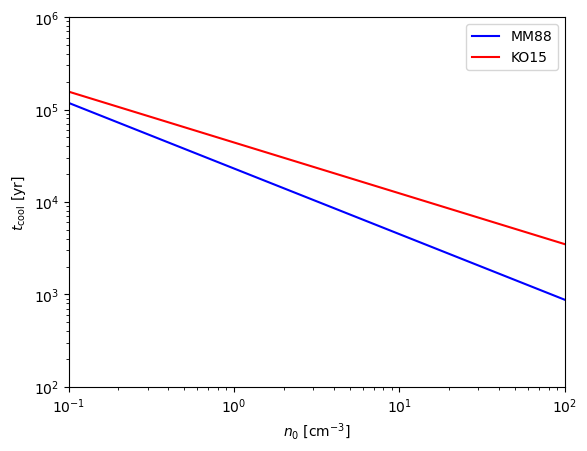

In [12]:
nlin = np.logspace(-1, 2, 1000) * u.cm**-3
Lw = 1e38 * u.erg/u.s
E_SN = 1e51 * u.erg

plt.plot(nlin, Tcool_MM88(nlin, Lw), label='MM88', color='blue')
plt.plot(nlin, Tcool_KO15(nlin, E_SN), label='KO15', color='red')

plt.legend()
plt.ylim(1e2, 1e6)
plt.xlim(1e-1,1e2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'$n_0$ [cm$^{-3}$]')
plt.ylabel(r'$t_{\rm sf}$ [yr]')

We can also look at the radius at which this occurs:

Text(0, 0.5, '$r_{\\rm cool}$ [pc]')

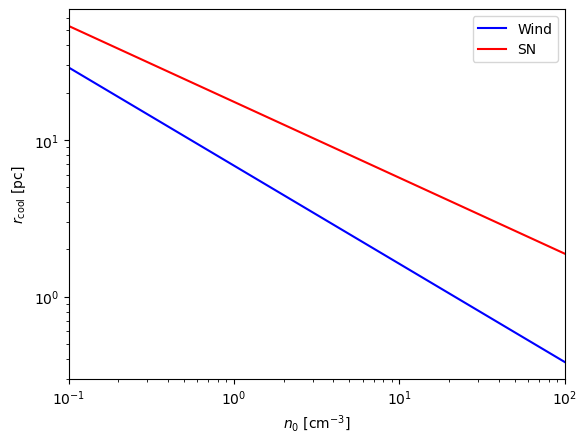

In [18]:
nlin = np.logspace(-1, 2, 1000) * u.cm**-3
Lw = 1e38 * u.erg/u.s
E_SN = 1e51 * u.erg

(rsf_ws, rsf_sns) = ([], [])
for n in nlin:
    weaver_sol = fb_models.EnergyDrivenWind(Lw = Lw, rho0=1.4*ac.m_p*n)
    sedov_sol = fb_models.SedovTaylorBW(E = E_SN, rho0=1.4*ac.m_p*n)
    rsf_ws.append(weaver_sol.radius(Tcool_MM88(n, Lw)).value)
    rsf_sns.append(sedov_sol.radius(Tcool_MM88(n, Lw)).value)
(rsf_ws, rsf_sns) = (np.array(rsf_ws), np.array(rsf_sns))

plt.plot(nlin, rsf_ws, label=r'Wind', color='blue')
plt.plot(nlin, rsf_sns, label=r'SN', color='red')

plt.legend()
#plt.ylim(1e2, 1e6)
plt.xlim(1e-1,1e2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'$n_0$ [cm$^{-3}$]')
plt.ylabel(r'$r_{\rm sf}$ [pc]')
